# QCHack 2021 IBM Technical Challenge
#### Richard Allen and Matthew Tyler
#### Harvard College 2022

Based on the proposition for more hardware efficient implementation of Toffoli gates using higher energy transmon states in https://arxiv.org/pdf/0804.0272.pdf, we have used the $| 2 \rangle$ state of IBM's superconducting qubits to execute a Toffoli gate using on three CNOTs, instead of the typical six required. We began by determining the resonant frequency $\omega_{02}$ of the $|0 \rangle \to |2 \rangle$ transition using a frequency sweep, motivated by the example in the Qiskit Textbook, then performed a Rabi pulse experiment at $\omega_{02}$ to determine the necessary pulse amplitude to perform an $X$ gate between the $| 0\rangle$ and $|2\rangle$ states. We then build the corresponding pulse and used it in a $3$ CNOT Toffoli gate. 

# Determining $\omega_{02}$

In [140]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from scipy.signal import find_peaks

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

import qiskit.pulse as pulse
import qiskit.pulse.library as pulse_lib
from qiskit.compiler import assemble
from qiskit.pulse.library import Waveform

from qiskit import QuantumCircuit, transpile, Aer, execute
from qiskit.tools.jupyter import *
from ibm_quantum_widgets import *
from qiskit.circuit import Gate
from qiskit.pulse.library import Gaussian
from qiskit.compiler import transpile, assemble
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

In [224]:
import warnings
warnings.filterwarnings('ignore')
from qiskit.tools.jupyter import *
%matplotlib inline

from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-university', group='harvard-lukin', project='phys160')
backend = provider.get_backend('ibmq_rome')

backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

dt = backend_config.dt

backend_defaults = backend.defaults()

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

qubit = 2 # qubit we will analyze
default_qubit_freq = backend_defaults.qubit_freq_est[qubit] # Default qubit frequency in Hz. 
print(f"Qubit {qubit} has an estimated frequency of {default_qubit_freq/ GHz} GHz.")

# scale data (specific to each device)
scale_factor = 1e-14

# number of shots for our experiments
NUM_SHOTS = 1024

### Collect the necessary channels
drive_chan = pulse.DriveChannel(qubit)
meas_chan = pulse.MeasureChannel(qubit)
acq_chan = pulse.AcquireChannel(qubit)

ibmqfactory.load_account:WARNING:2021-04-10 22:27:58,580: Credentials are already in use. The existing account in the session will be replaced.


Qubit 2 has an estimated frequency of 5.015166836927508 GHz.


In [225]:
def get_job_data(job, average):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data. 
    """
    job_results = job.result(timeout=120) # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average: # get avg data
            result_data.append(job_results.get_memory(i)[qubit]*scale_factor) 
        else: # get single data
            result_data.append(job_results.get_memory(i)[:, qubit]*scale_factor)  
    return result_data

def get_closest_multiple_of_16(num):
    """Compute the nearest multiple of 16. Needed because pulse enabled devices require 
    durations which are multiples of 16 samples.
    """
    return (int(num) - (int(num)%16))

In [226]:
# Drive pulse parameters (us = microseconds)
drive_sigma_us = 0.05                     # This determines the actual width of the gaussian
drive_samples_us = drive_sigma_us*8        # This is a truncating parameter, because gaussians don't have 
                                           # a natural finite length

drive_sigma = get_closest_multiple_of_16(drive_sigma_us * us /dt)       # The width of the gaussian in units of dt
drive_samples = get_closest_multiple_of_16(drive_samples_us * us /dt)   # The truncating parameter in units of dt

In [227]:
# Find out which measurement map index is needed for this qubit
meas_map_idx = None
for i, measure_group in enumerate(backend_config.meas_map):
    if qubit in measure_group:
        meas_map_idx = i
        break
assert meas_map_idx is not None, f"Couldn't find qubit {qubit} in the meas_map!"

In [228]:
# Get default measurement pulse from instruction schedule map
inst_sched_map = backend_defaults.instruction_schedule_map
measure = inst_sched_map.get('measure', qubits=backend_config.meas_map[meas_map_idx])

### 1A. $|0 \rangle \to |2 \rangle$ Frequency Sweep

In [229]:
def create_ground_freq_sweep_program(freqs, drive_power):
    """Builds a program that does a freq sweep by exciting the ground state. 
    Depending on drive power this can reveal the 0->1 frequency or the 0->2 frequency. 
    Args:
        freqs (np.ndarray(dtype=float)): Numpy array of frequencies to sweep.
        drive_power (float) : Value of drive amplitude.
    Raises:
        ValueError: Raised if use more than 75 frequencies; currently, an error will be thrown on the backend 
                    if you try to do this.
    Returns:
        Qobj: Program for ground freq sweep experiment.
    """
    if len(freqs) > 75:
        raise ValueError("You can only run 75 schedules at a time.")
    
    # print information on the sweep
    print(f"The frequency sweep will go from {freqs[0] / GHz} GHz to {freqs[-1]/ GHz} GHz \
using {len(freqs)} frequencies. The drive power is {drive_power}.")
    
    # Define the drive pulse
    ground_sweep_drive_pulse = pulse_lib.gaussian(duration=drive_samples,
                                                  sigma=drive_sigma,
                                                  amp=drive_power,
                                                  name='ground_sweep_drive_pulse')
    # Create the base schedule
    schedule = pulse.Schedule(name='Frequency sweep starting from ground state.')
    
    schedule |= pulse.Play(ground_sweep_drive_pulse, drive_chan)
    schedule |= measure << schedule.duration
    
    # define frequencies for the sweep
    schedule_freqs = [{drive_chan: freq} for freq in freqs]

    # assemble the program
    # Note: we only require a single schedule since each does the same thing;
    # for each schedule, the LO frequency that mixes down the drive changes
    # this enables our frequency sweep
    ground_freq_sweep_program = assemble(schedule,
                                         backend=backend, 
                                         meas_level=1,
                                         meas_return='avg',
                                         shots=NUM_SHOTS,
                                         schedule_los=schedule_freqs)
    
    return ground_freq_sweep_program

In [230]:
# We will sweep 40 MHz around the estimated frequency, with 75 frequencies
num_freqs = 75
ground_sweep_freqs = default_qubit_freq + np.linspace(-20*MHz, 20*MHz, num_freqs)
ground_freq_sweep_program = create_ground_freq_sweep_program(ground_sweep_freqs, drive_power=0.5)

The frequency sweep will go from 4.995166836927508 GHz to 5.035166836927508 GHz using 75 frequencies. The drive power is 0.5.


In [231]:
ground_freq_sweep_job = backend.run(ground_freq_sweep_program)

In [232]:
job_id_no = ground_freq_sweep_job.job_id()
print(ground_freq_sweep_job.job_id())
job_monitor(ground_freq_sweep_job)

6072267f159ff91d8e3f0551
Job Status: job has successfully run


In [233]:
# Get the job data (average)
ground_freq_sweep_data = get_job_data(provider.backend.retrieve_job(job_id_no), average=True)

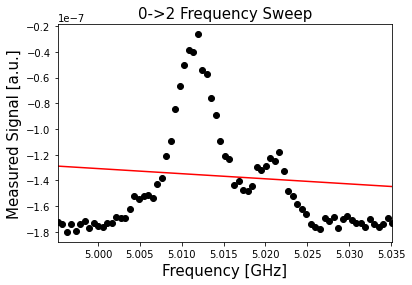

In [236]:
# Note: we are only plotting the real part of the signal
plt.scatter(ground_sweep_freqs/GHz, ground_freq_sweep_data, color='black')
plt.xlim([min(ground_sweep_freqs/GHz), max(ground_sweep_freqs/GHz)])
plt.xlabel("Frequency [GHz]", fontsize=15)
plt.ylabel("Measured Signal [a.u.]", fontsize=15)
plt.title("0->2 Frequency Sweep", fontsize=15)
plt.show()

In [242]:
#_, cal_qubit_freq, _, _ = ground_sweep_fit_params
cal_qubit_freq = ground_sweep_freqs[ground_freq_sweep_data.index(max(ground_freq_sweep_data[37:75]))]
print(f"We've updated our qubit frequency estimate from "
      f"{round(default_qubit_freq/GHz, 7)} GHz to {round(cal_qubit_freq/GHz, 7)} GHz.")

We've updated our qubit frequency estimate from 5.0151668 GHz to 5.0216533 GHz.


### 1B. $| 0 \rangle \to | 2 \rangle$ Rabi Experiment

In [325]:
# experimental configuration
num_rabi_points = 50 # number of experiments (ie amplitudes to sweep out)

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = 0.6
drive_amp_max = 0.7
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [326]:
# Create schedule
rabi_01_schedules = []
# loop over all drive amplitudes
for ii, drive_amp in enumerate(drive_amps):
    # drive pulse
    rabi_01_pulse = pulse_lib.gaussian(duration=drive_samples, 
                                       amp=drive_amp, 
                                       sigma=drive_sigma, 
                                       name='rabi_01_pulse_%d' % ii)
    
    # add commands to schedule
    schedule = pulse.Schedule(name='Rabi Experiment at drive amp = %s' % drive_amp)
    schedule |= pulse.Play(rabi_01_pulse, drive_chan)
    schedule |= measure << schedule.duration # shift measurement to after drive pulse
    rabi_01_schedules.append(schedule)

In [327]:
# Assemble the schedules into a program
# Note: We drive at the calibrated frequency.
rabi_01_expt_program = assemble(rabi_01_schedules,
                                backend=backend,
                                meas_level=1,
                                meas_return='avg',
                                shots=NUM_SHOTS,
                                schedule_los=[{drive_chan: int(5.0216533*GHz)}]
                                               * num_rabi_points)

In [328]:
rabi_01_job = backend.run(rabi_01_expt_program)

In [329]:
print(rabi_01_job.job_id())
job_monitor(rabi_01_job)

607232b3159ff9314a3f05a9
Job Status: job has successfully run


In [332]:
# Get the job data (average)
rabi_01_data = get_job_data(rabi_01_job, average=True)

In [333]:
def baseline_remove(values):
    """Center data around 0."""
    return np.array(values) - np.mean(values)

In [ ]:
def fit_function(x_values, y_values, function, init_params):
    """Fit a function using scipy curve_fit."""
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    
    return fitparams, y_fit

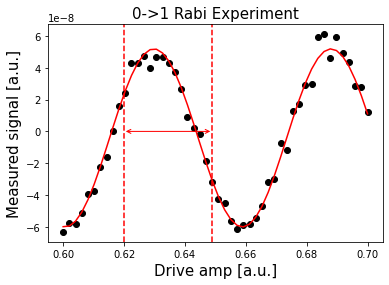

In [338]:
# Note: Only real part of data is plotted
rabi_01_data = np.real(baseline_remove(rabi_01_data))
(rabi_01_fit_params, 
 rabi_01_y_fit) = fit_function(drive_amps,
                             rabi_01_data, 
                              lambda x, A, B, drive_01_period, phi: (A*np.cos(2*np.pi*(x-0.65)/drive_01_period - phi) + B),
                              [-6, 6, 0.075, 65])

plt.scatter(drive_amps, rabi_01_data, color='black')

plt.plot(drive_amps, rabi_01_y_fit, color='red')

drive_01_period = rabi_01_fit_params[2] 
# account for phi in computing pi amp
pi_amp_01 = (drive_01_period/2/np.pi) *(np.pi+rabi_01_fit_params[3])

plt.axvline(pi_amp_01, color='red', linestyle='--')
plt.axvline(pi_amp_01+drive_01_period/2, color='red', linestyle='--')
plt.annotate("", xy=(pi_amp_01+drive_01_period/2, 0), xytext=(pi_amp_01,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(pi_amp_01-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.title('0->1 Rabi Experiment', fontsize=15)
plt.show()

In [337]:
print(f"Pi Amplitude (0->1) = {pi_amp_01}")

Pi Amplitude (0->1) = 0.6199097504093395


### 2. Building the Modified Toffoli Gate

In [ ]:
second_freq=5.021*GHz
pulse_amp=0.6

In [ ]:
#The initial sequence of X gates can be modified to change input states and verify the fidelity of the Toffoli gate

circ = QuantumCircuit(3,3)
x_a = Gate('xa', 1,[])
circ.h(2)
circ.x(1)
circ.append(x_a,[2])
circ.cx(1,2)
circ.cz(0,2)
circ.cx(1,2)
circ.append(x_a,[2])
circ.x(1)
circ.h(2)
circ.measure(0,0)
circ.measure(1,1)
circ.measure(2,2)
with pulse.build(backend, name='custom') as my_schedule:
    pulse.set_frequency(int(second_freq),pulse.drive_channel(2))
    pulse.play(Gaussian(duration=drive_samples, amp=pulse_amp, sigma=drive_sigma), pulse.drive_channel(2))
    
    
circ.add_calibration('xa', [2], my_schedule)
circ.draw('mpl')
initial_layout=[1,3,2]
circ = transpile(circ, backend, initial_layout=initial_layout, optimization_level=1)
job = execute(circ, backend=backend, shots=1024)
job_monitor(job)
result = job.result() 

In [ ]:
counts = result.get_counts()
plot_histogram(counts)